In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.utils import resample
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

In [3]:
# Import data
porphyry_WR = pd.read_csv("/content/drive/MyDrive/Geochemistry Dataset/PorphyryWR.csv",  encoding= 'unicode_escape' )
GEOROC_WR = pd.read_csv("/content/drive/MyDrive/Geochemistry Dataset/all_GEOROC_data_processed.csv")

In [4]:
# Getting details of porphyry_WR data frame
print("Details of porphyry_WR data frame:")
print(porphyry_WR.info())

Details of porphyry_WR data frame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Fertility     640 non-null    int64  
 1   Magma_Series  640 non-null    object 
 2   Deposit       640 non-null    object 
 3   AUTHOR        640 non-null    object 
 4   Si            640 non-null    float64
 5   Al            640 non-null    float64
 6   Fe            640 non-null    float64
 7   Mg            640 non-null    float64
 8   Ca            640 non-null    float64
 9   Na            640 non-null    float64
 10  K             640 non-null    float64
 11  Ti            640 non-null    float64
 12  Mn            640 non-null    float64
 13  Sr            640 non-null    float64
 14  Y             640 non-null    float64
 15  La            638 non-null    float64
 16  Ce            640 non-null    float64
 17  Pr            640 non-null    float64


In [5]:
# Getting details of GEOROC_WR data frame
print("\nDetails of GEOROC_WR data frame:")
print(GEOROC_WR.info())


Details of GEOROC_WR data frame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Si      3216 non-null   float64
 1   Al      3216 non-null   float64
 2   Fe      3216 non-null   float64
 3   Mg      3216 non-null   float64
 4   Ca      3216 non-null   float64
 5   Na      3216 non-null   float64
 6   K       3216 non-null   float64
 7   Ti      3216 non-null   float64
 8   Mn      3216 non-null   float64
 9   Sr      3216 non-null   float64
 10  Y       3216 non-null   float64
 11  La      3216 non-null   float64
 12  Ce      3216 non-null   float64
 13  Pr      3216 non-null   float64
 14  Nd      3216 non-null   float64
 15  Sm      3216 non-null   float64
 16  Eu      3216 non-null   float64
 17  Gd      3216 non-null   float64
 18  Tb      3216 non-null   float64
 19  Dy      3216 non-null   float64
 20  Ho      3216 non-null   float64
 21  Er 

In [6]:
labels =  porphyry_WR['Fertility']
data = porphyry_WR.drop('Fertility', axis = 1)

In [7]:
# Check shape of labels and data
print("Shape of labels:", labels.shape)
print("Shape of data:", data.shape)

# Count number of samples in 'Fertile' (1) and 'Infertile' (0) categories
fertile_count = (labels == 1).sum()
infertile_count = (labels == 0).sum()

print("Number of samples in 'Fertile':", fertile_count)
print("Number of samples in 'Infertile':", infertile_count)

Shape of labels: (640,)
Shape of data: (640, 28)
Number of samples in 'Fertile': 493
Number of samples in 'Infertile': 147


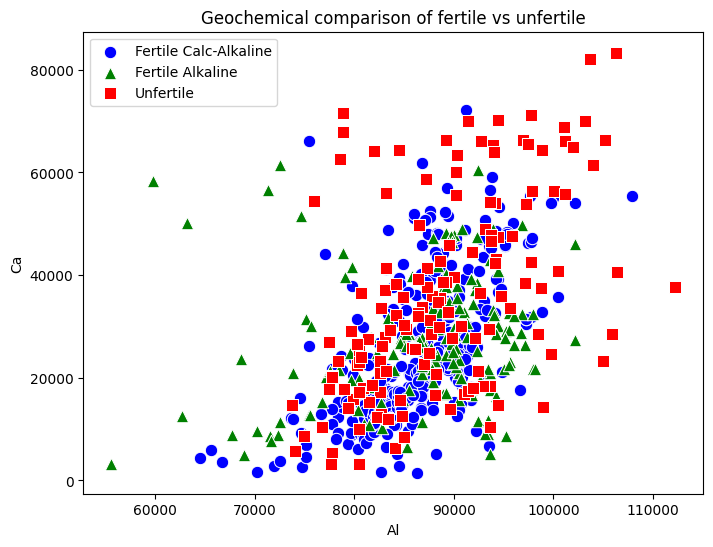

In [10]:
# Filter data for different categories
calc_alkaline_data = porphyry_WR[porphyry_WR['Magma_Series'] == 'CA']
alkaline_data = porphyry_WR[porphyry_WR['Magma_Series'] == 'K']

fertile_calc_alkaline_df = calc_alkaline_data[calc_alkaline_data['Fertility'] == 1]
fertile_alkaline_df = alkaline_data[alkaline_data['Fertility'] == 1]
unfertile_df = porphyry_WR[porphyry_WR['Fertility'] == 0]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

# Plot each category with distinct markers and colors
sns.scatterplot(data=fertile_calc_alkaline_df, x='Al', y='Ca', label='Fertile Calc-Alkaline', s=80, marker='o', color='blue')
sns.scatterplot(data=fertile_alkaline_df, x='Al', y='Ca', label='Fertile Alkaline', s=80, marker='^', color='green')
sns.scatterplot(data=unfertile_df, x='Al', y='Ca', label='Unfertile', s=80, marker='s', color='red')

plt.xlabel('Al')
plt.ylabel('Ca')
plt.title('Geochemical comparison of fertile vs unfertile')
plt.legend()
plt.grid(False)
plt.savefig("Fertile vs Unfertile", dpi=300)
plt.show()

In [11]:
# This function calculates the centred log ratio transformation of a compositional dataset
def clr(compositional_data):
  compositional_data += 1e-9
  # the geometric mean acts as the center of the composition
  geom_mean = np.power(np.prod(compositional_data,axis=1),1/len(compositional_data.columns))
  return np.log(compositional_data.div(geom_mean,axis=0))

# Assuming porphyry_WR.iloc[:,4:] and GEOROC_WR contain the compositional data
porphyry_WR_clr = clr(porphyry_WR.iloc[:,4:])
GEOROC_WR_clr = clr(GEOROC_WR)

# Join datasets
X = pd.concat([porphyry_WR_clr, GEOROC_WR_clr], axis = 0)
y = porphyry_WR['Fertility']
y = np.pad(y, (0, len(GEOROC_WR)), 'constant')
X['Fertility'] = y
X = X.dropna(inplace=False)
y = X['Fertility']
x = X.drop('Fertility', axis = 1)

# Check shape of labels and data
print("Shape of labels:", y.shape)
print("Shape of data:", x.shape)

# Count number of samples in 'Fertile' (1) and 'Infertile' (0) categories
fertile_count = (y == 1).sum()
infertile_count = (y == 0).sum()

print("Number of samples in 'Fertile':", fertile_count)
print("Number of samples in 'Infertile':", infertile_count)

Shape of labels: (3845,)
Shape of data: (3845, 25)
Number of samples in 'Fertile': 484
Number of samples in 'Infertile': 3361


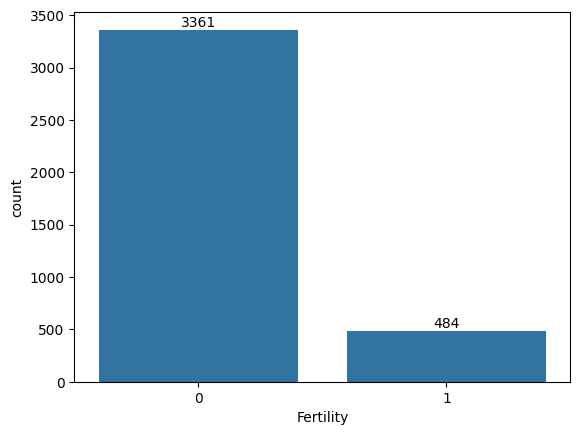

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the countplot
ax = sns.countplot(x=y)
#plt.title('Before SMOTE')

# Add the number of samples on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 1,
        f'{int(height)}',
        ha='center', va='bottom'
    )

plt.savefig("Before SMOTE", dpi=300)
plt.show()


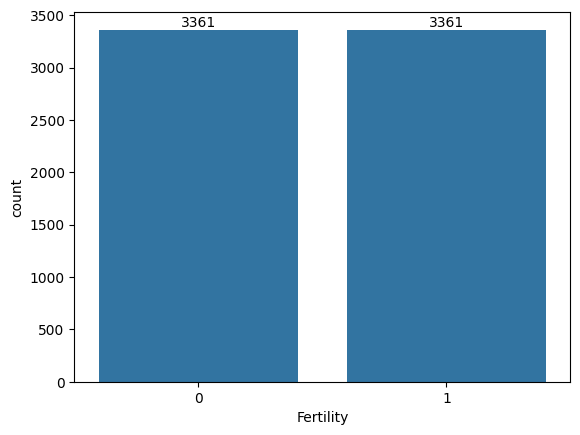

Shape of x_smote: (6722, 25)
Shape of y_smote: (6722,)


In [19]:
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Apply SMOTE to the dataset
smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(x, y)

# Create a countplot to show the class distribution after SMOTE
ax = sns.countplot(x=y_smote)
#plt.title('After SMOTE')

# Add sample counts on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 1,
        f'{int(height)}',
        ha='center', va='bottom'
    )
plt.savefig("After SMOTE", dpi=300)
plt.show()

# Print the new shapes
print("Shape of x_smote:", x_smote.shape)
print("Shape of y_smote:", y_smote.shape)


Training Ensemble...
Training MLP...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Training SVM...
Training Random Forest...
Training Logistic Regression...

Results for Ensemble:
Accuracy: 0.9735
Recall: 0.9896
Precision: 0.9589
F1-score: 0.9740

Results for MLP:
Accuracy: 0.9699
Recall: 0.9848
Precision: 0.9564
F1-score: 0.9704

Results for SVM:
Accuracy: 0.9506
Recall: 0.9569
Precision: 0.9452
F1-score: 0.9509

Results for Random Forest:
Accuracy: 0.8667
Recall: 0.8319
Precision: 0.8943
F1-score: 0.8618

Results for Logistic Regression:
Accuracy: 0.8628
Recall: 0.8483
Precision: 0.8741
F1-score: 0.8608


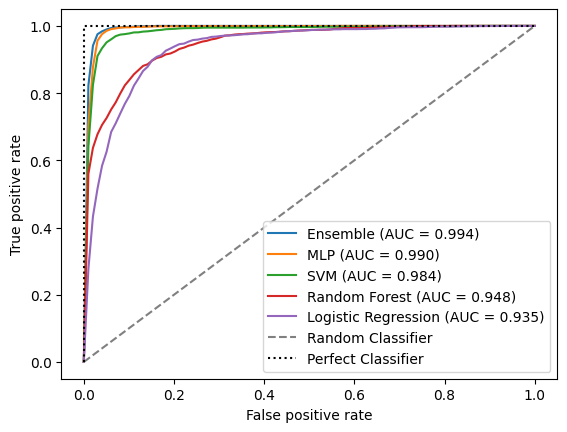

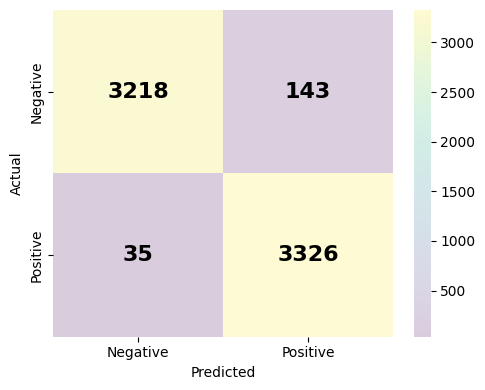

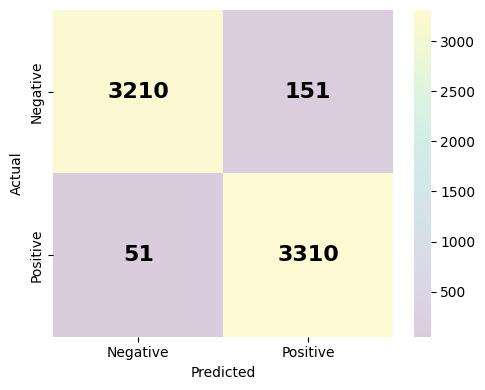

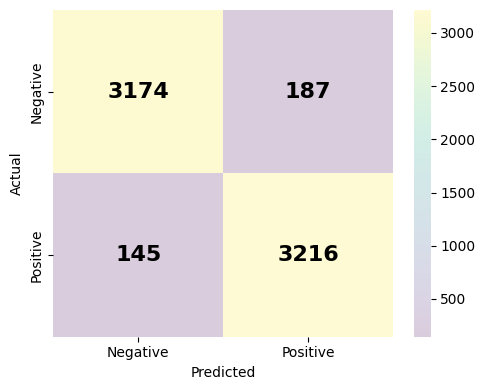

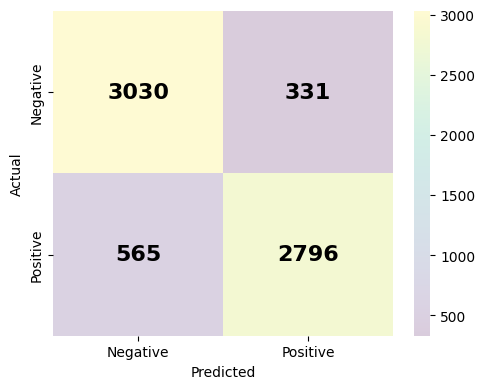

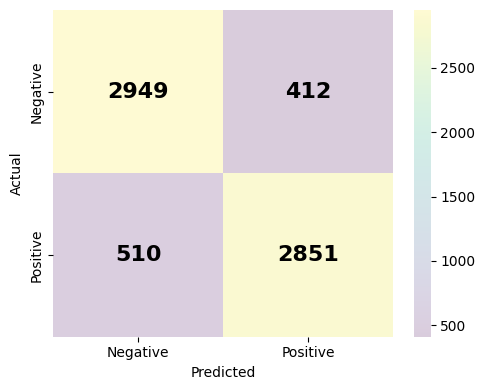

In [20]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Standardize features
scaler = StandardScaler()
x_smote_scaled = scaler.fit_transform(x_smote)

# Base classifiers for ensemble
dt = DecisionTreeClassifier(max_depth=4, random_state=0)
knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=4))
rf = RandomForestClassifier(n_estimators=50, max_depth=4, random_state=0)
gb = GradientBoostingClassifier(n_estimators=250, learning_rate=0.07, max_depth=4, random_state=0)

# Boosted Ensemble
voting_clf = VotingClassifier(
    estimators=[('dt', dt), ('knn', knn), ('rf', rf), ('gb', gb)],
    voting='soft',
    weights=[1, 4, 1, 6]
)

# Classifier dictionary
classifiers = {
    "Ensemble": voting_clf,
    "MLP": make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(50,), max_iter=200, random_state=0)),
    "SVM": make_pipeline(StandardScaler(), SVC(probability=True, kernel='rbf', random_state=0)),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=4, random_state=0),
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=0))
}

# Initialize evaluation structures
metrics = ["Accuracy", "Recall", "Precision", "F1-score"]
results = {metric: {clf_name: [] for clf_name in classifiers.keys()} for metric in metrics}
conf_matrices = {clf_name: None for clf_name in classifiers.keys()}
mean_fpr = np.linspace(0, 1, 100)
roc_curves = {clf_name: {"tpr": [], "auc": []} for clf_name in classifiers.keys()}

# 10-fold CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Training and evaluation loop
for clf_name, clf in classifiers.items():
    print(f"Training {clf_name}...")
    for train_idx, test_idx in cv.split(x_smote_scaled, y_smote):
        X_train, X_test = x_smote_scaled[train_idx], x_smote_scaled[test_idx]
        y_train, y_test = y_smote.iloc[train_idx], y_smote.iloc[test_idx]

        clf.fit(X_train, y_train)
        y_probs = clf.predict_proba(X_test)
        y_pred = (y_probs[:, 1] > 0.5).astype(int)

        # Evaluate
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results["Accuracy"][clf_name].append(acc)
        results["Recall"][clf_name].append(rec)
        results["Precision"][clf_name].append(prec)
        results["F1-score"][clf_name].append(f1)

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        if conf_matrices[clf_name] is None:
            conf_matrices[clf_name] = cm
        else:
            conf_matrices[clf_name] += cm

        # ROC
        fpr, tpr, _ = roc_curve(y_test, y_probs[:, 1])
        roc_curves[clf_name]["tpr"].append(np.interp(mean_fpr, fpr, tpr))
        roc_curves[clf_name]["tpr"][-1][0] = 0.0
        roc_auc = roc_auc_score(y_test, y_probs[:, 1])
        roc_curves[clf_name]["auc"].append(roc_auc)

# Print average metrics and plot ROC
for clf_name in classifiers:
    print(f"\nResults for {clf_name}:")
    for metric in metrics:
        avg = np.mean(results[metric][clf_name])
        print(f"{metric}: {avg:.4f}")

    mean_tpr = np.mean(roc_curves[clf_name]["tpr"], axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(roc_curves[clf_name]["auc"])
    plt.plot(mean_fpr, mean_tpr, label=f'{clf_name} (AUC = {mean_auc:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Classifier')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
#plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig("roc_plots.png", dpi=300)
plt.show()

# Confusion matrix plots
for clf_name, cm in conf_matrices.items():
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(cm, annot=False, cmap='viridis', alpha=0.2,
                     xticklabels=['Negative', 'Positive'],
                     yticklabels=['Negative', 'Positive'])


    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = ax.text(j + 0.5, i + 0.5, cm[i, j],
                           ha='center', va='center', color='black',
                           fontsize=16, fontweight='bold')


    #plt.title(f'Confusion Matrix for {clf_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{clf_name}.png', dpi=300)
    plt.show()


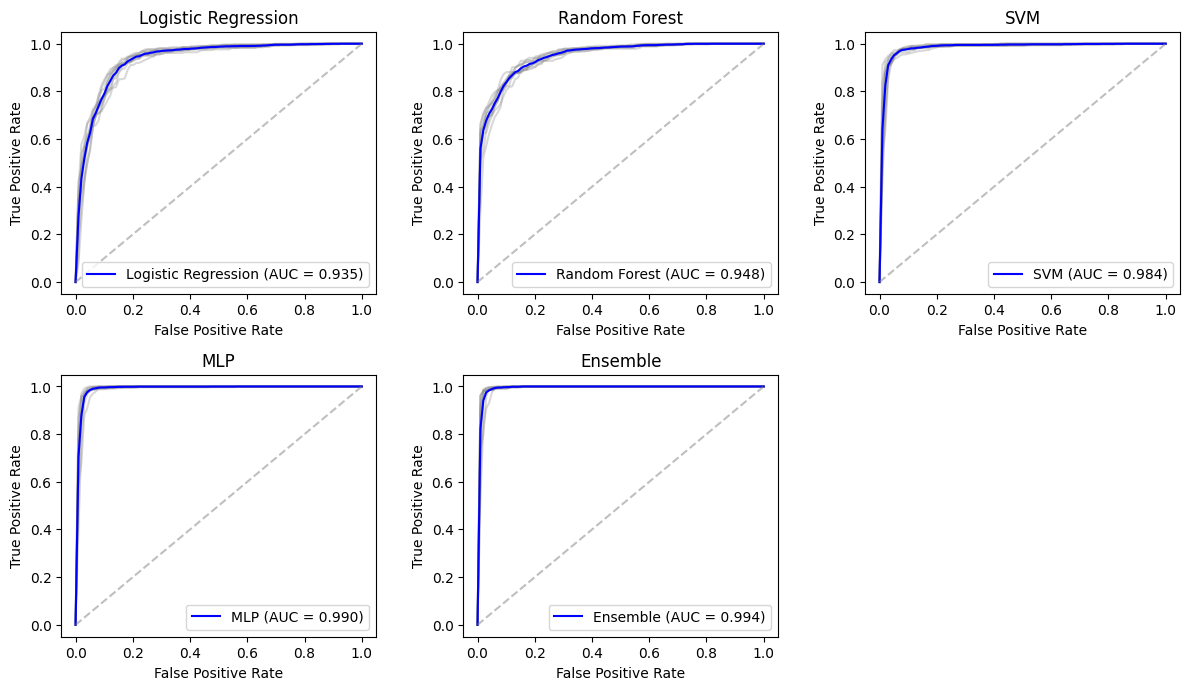

In [25]:
# Define the desired classifier order
classifier_order = ["Logistic Regression", "Random Forest", "SVM", "MLP", "Ensemble"]

plt.figure(figsize=(12, 10))

for i, clf_name in enumerate(classifier_order, start=1):
    roc_data = roc_curves[clf_name]

    plt.subplot(3, 3, i)

    # Plot ROC curves for each fold in grey
    for tpr in roc_data["tpr"]:
        plt.plot(mean_fpr, tpr, color='grey', alpha=0.3)

    # Plot mean ROC curve
    mean_tpr = np.mean(roc_data["tpr"], axis=0)
    mean_auc = np.mean(roc_data["auc"])
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'{clf_name} (AUC = {mean_auc:.3f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(clf_name)
    plt.legend()

plt.tight_layout()
plt.savefig("roc_plots_individual.png", dpi=300)
plt.show()


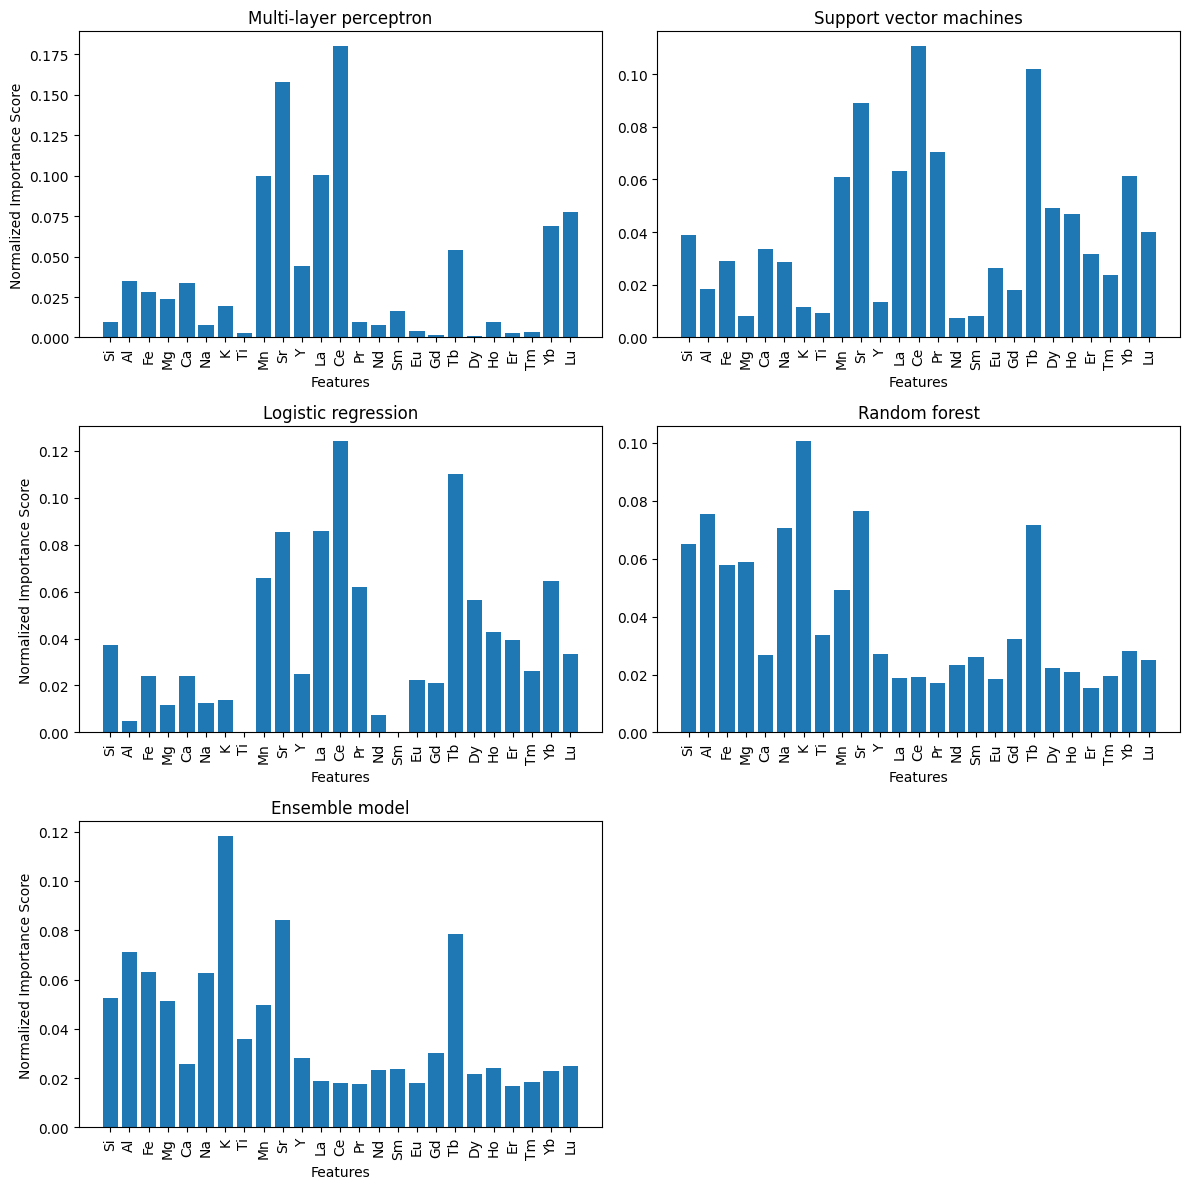

In [22]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt

# Define classifiers
classifiers = {
    "Ensemble": VotingClassifier(
    estimators=[('dt', DecisionTreeClassifier(random_state=0)), ('knn', KNeighborsClassifier()), ('rf', RandomForestClassifier(n_estimators=200, random_state=0)), ('gb', GradientBoostingClassifier())],
    weights=[1, 4, 1, 6], voting='soft'
),
    "MLP": MLPClassifier(max_iter=1000),
    "SVM": make_pipeline(StandardScaler(), SVC(probability=True, kernel='linear')),
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000)),
    "Random Forest": RandomForestClassifier()
}

# Train each classifier and calculate feature importance scores
importance_scores_dict = {}
for clf_name, clf in classifiers.items():
    # Assuming x_smote is your training data and y_smote is your training labels
    if "Ensemble" in clf_name:
        # For ensemble, we need to fit on scaled data
        clf.fit(x_smote_scaled, y_smote)
    else:
        clf.fit(x_smote, y_smote)


    # Calculate feature importance scores
    if clf_name == "Random Forest":
        importance_scores = clf.feature_importances_
    elif clf_name == 'Ensemble':
        # Access the RandomForestClassifier within the VotingClassifier
        importance_scores = clf.estimators_[2].feature_importances_
    elif clf_name == "Logistic Regression":
        importance_scores = np.abs(clf.named_steps['logisticregression'].coef_[0])
    elif clf_name == "SVM":
        importance_scores = np.abs(clf.named_steps['svc'].coef_[0])
    elif clf_name == "MLP":
        results = permutation_importance(clf, x_smote, y_smote, n_repeats=10, random_state=42, n_jobs=-1)
        importance_scores = results.importances_mean


    importance_scores_dict[clf_name] = importance_scores

  # Assuming X_train is your training data stored in a DataFrame
feature_names = x.columns.tolist()


import numpy as np
import matplotlib.pyplot as plt

def plot_normalized_feature_importance(ax, importance_scores, feature_names, classifier_name, show_ylabel=True):
    # Check if lengths of feature_names and importance_scores match
    if len(feature_names) != len(importance_scores):
        raise ValueError("Lengths of feature_names and importance_scores do not match.")

    # Normalize the importance scores
    normalized_scores = importance_scores / np.sum(importance_scores)

    # Plot the bar graph without sorting
    ax.bar(range(len(feature_names)), normalized_scores)
    ax.set_xticks(range(len(feature_names)))
    ax.set_xticklabels(feature_names, rotation=90)
    if show_ylabel:
        ax.set_ylabel('Normalized Importance Score')
    ax.set_xlabel('Features')
    ax.set_title(f'{classifier_name}')

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# Plot for each classifier
plot_normalized_feature_importance(axes[0], importance_scores_dict['MLP'], feature_names, "Multi-layer perceptron", show_ylabel=True)
plot_normalized_feature_importance(axes[1], importance_scores_dict['SVM'], feature_names, "Support vector machines", show_ylabel=False)
plot_normalized_feature_importance(axes[2], importance_scores_dict['Logistic Regression'], feature_names, "Logistic regression", show_ylabel=True)
plot_normalized_feature_importance(axes[3], importance_scores_dict['Random Forest'], feature_names, "Random forest", show_ylabel=False)
plot_normalized_feature_importance(axes[4], importance_scores_dict['Ensemble'], feature_names, "Ensemble model", show_ylabel=True)

# Hide the last subplot as it is empty
axes[5].set_visible(False)


plt.tight_layout()
plt.savefig(f'feature_Importance_grid.png', dpi=300, bbox_inches='tight')
plt.show()

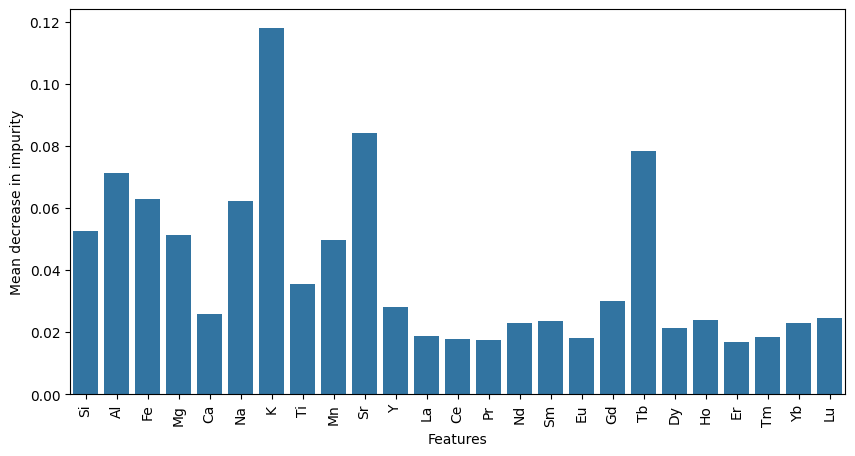

In [29]:
# Calculate Gini importance for the Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, random_state=0)
rf_model.fit(x_smote, y_smote)
gini_importance = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Gini Importance': gini_importance})

# Plot the feature importances
plt.figure(figsize=(10, 5))
sns.barplot(x='Feature', y='Gini Importance', data=feature_importance_df)
#plt.title('Gini importance')
plt.xlabel('Features')
plt.ylabel('Mean decrease in impurity')
plt.xticks(rotation=90)
plt.savefig('Gini_importance.png', dpi=300)
plt.show()

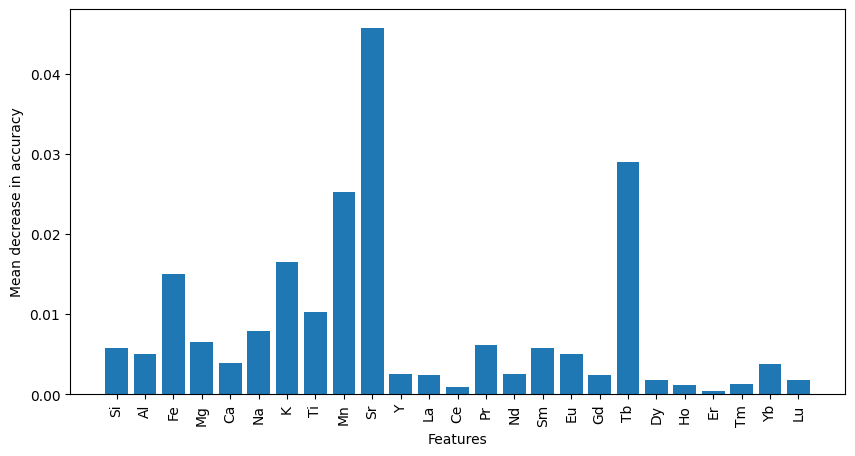

In [30]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
x_smote_scaled = scaler.fit_transform(x_smote)

# Fit the ensemble model to the training data
voting_clf.fit(x_smote_scaled, y_smote)

# Compute permutation importance
result = permutation_importance(voting_clf, x_smote_scaled, y_smote, n_repeats=10, random_state=42)

# Extract the importance scores
importance_scores = result.importances_mean
feature_names = x.columns

# Plot the feature importances with features on the x-axis and mean accuracy decrease on the y-axis
plt.figure(figsize=(10, 5))
plt.bar(feature_names, importance_scores)
plt.ylabel('Mean decrease in accuracy')
plt.xlabel('Features')
#plt.title('Permutation importance')
plt.xticks(rotation=90)
plt.savefig('permutation_importance.png', dpi=300)
plt.show()